In [ ]:
# Roboflow에서 데이터셋 다운로드
!curl -L "https://public.roboflow.com/ds/WR5OCb87sw?key=2dbcCWGChe" > roboflow.zip
!unzip roboflow.zip
!rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   910  100   910    0     0   3238      0 --:--:-- --:--:-- --:--:--  3238
100 46.0M  100 46.0M    0     0  38.1M      0  0:00:01  0:00:01 --:--:--  104M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/images/img

In [ ]:
# YOLOv5 GitHub 레포지토리 클론
!git clone https://github.com/Yunseo-Lab/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14225, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 14225 (delta 52), reused 18 (delta 18), pack-reused 14156 (from 3)
Receiving objects: 100% (14225/14225), 34.59 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (9472/9472), done.


In [ ]:
# YOLOv5 디렉토리로 이동 후 requirements 설치
%cd /content/yolov5
!pip install -r requirements.txt

/content/yolov5


In [ ]:
# 학습 설정 파일(data.yaml) 내용 확인
%cat /content/data.yaml

names:
- pothole
nc: 1
train: /content/train/train.txt
val: /content/valid/val.txt


In [ ]:
from glob import glob

# 학습 이미지 경로 수집
train_img_list = glob('/content/train/images/*.jpg')
print("Train:", len(train_img_list))

# 검증 이미지 경로 수집
valid_img_list = glob('/content/valid/images/*.jpg')
print("Valid:", len(valid_img_list))

# 테스트 이미지 경로 수집
test_img_list = glob('/content/test/images/*.jpg')
print("Test:", len(test_img_list))

Train: 465
Valid: 133
Test: 67


In [ ]:
# 학습/검증 이미지 경로 텍스트 파일 저장
with open('/content/train/train.txt', 'w') as f:
    f.write('\n'.join(train_img_list) + '\n')

with open('/content/valid/val.txt', 'w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

# data.yaml 업데이트
import yaml
with open('/content/data.yaml', 'r') as f:
    data = yaml.full_load(f)

data['train'] = '/content/train/train.txt'
data['val'] = '/content/valid/val.txt'

with open('/content/data.yaml', 'w') as f:
    yaml.dump(data, f)

print(data)

{'names': ['pothole'], 'nc': 1, 'train': '/content/train/train.txt', 'val': '/content/valid/val.txt'}


## Test

detect: weights=['/content/yolov5/runs/train/gun_yolov5s_results/weights/best.pt'], source=/content/valid/images/img-20_jpg.rf.fe0915e38abca9ba6523c4a4fd8dc779.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 a3fee43 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/valid/images/img-20_jpg.rf.fe0915e38abca9ba6523c4a4fd8dc779.jpg: 416x416 2 potholes, 7.1ms
Speed: 0.4ms pre-process, 7.1ms inference, 125.8ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp2


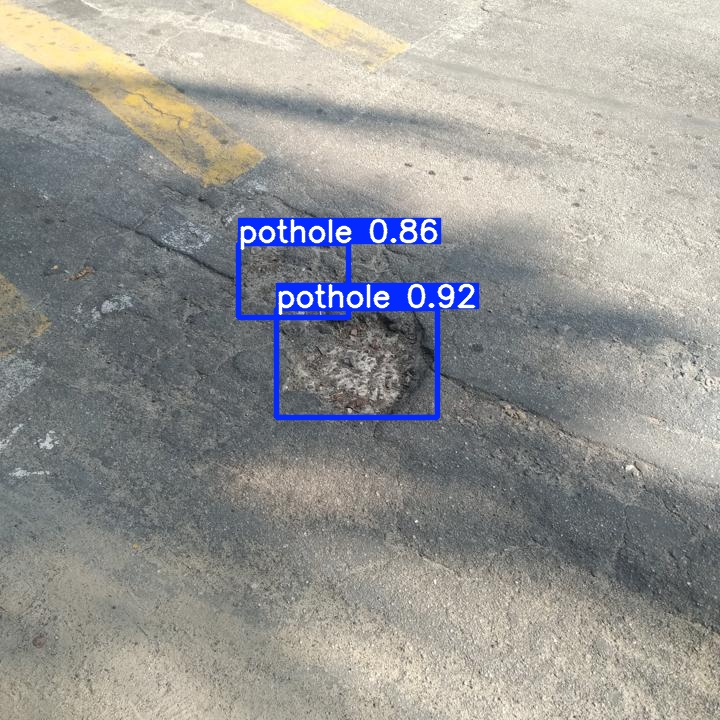

In [ ]:
from IPython.display import Image
import os

val_img_path = valid_img_list[1]

# 이미지 감지 수행
!python detect.py --weights /content/yolov5/runs/train/gun_yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source "{val_img_path}"

# 감지된 이미지 출력
Image(os.path.join('/content/yolov5/runs/detect/exp', os.path.basename(val_img_path)))

# Detect and send porthole info to server

In [ ]:
"""
포트홀 감지 모듈

이 모듈은 이미지나 센서 데이터로부터 포트홀을 감지하고
API 서버에 새로운 포트홀 정보를 전송하는 기능을 제공합니다.
"""

import requests
import json
from typing import Dict, Optional, Tuple, Union, List
import os
import cv2
import torch
import numpy as np

# API 서버 URL
API_SERVER_URL = "https://hydrocodone-briefing-wc-elegant.trycloudflare.com/api/notify_new_porthole"

# 모델 로드를 위한 전역 변수
yolo_model = None
midas = None
transform = None
device = None

def load_models():
    """
    YOLOv5와 MiDaS 모델을 로드합니다.
    """
    global yolo_model, midas, transform, device

    if yolo_model is not None:
        return  # 이미 모델이 로드되었으면 다시 로드하지 않음

    try:
        print("포트홀 감지 및 깊이 추정 모델 로드 중...")

        # 커스텀 학습된 YOLOv5 모델 로드 (포트홀 탐지용)
        yolo_model = torch.hub.load(
            'ultralytics/yolov5', 'custom',
            path='/content/yolov5/runs/train/gun_yolov5s_results/weights/best.pt'
        )
        yolo_model.eval()

        # MiDaS 모델 로드 (깊이 추정용)
        model_type = "DPT_Hybrid"  # 빠른 처리용 소형 모델
        midas = torch.hub.load("intel-isl/MiDaS", model_type)

        # CPU 또는 GPU 장치 설정
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        midas.to(device)
        midas.eval()

        # MiDaS 입력 이미지 변환 함수 로딩
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        transform = midas_transforms.small_transform

        print(f"모델 로드 완료 (장치: {device})")
        return True

    except Exception as e:
        print(f"모델 로드 중 오류 발생: {e}")
        return False

def detect_porthole_with_models(image_path: str) -> Tuple[bool, List[Dict]]:
    """
    YOLOv5와 MiDaS 모델을 사용하여 이미지에서 포트홀을 감지하고 깊이를 추정합니다.

    Args:
        image_path (str): 분석할 이미지 파일 경로

    Returns:
        Tuple[bool, List[Dict]]: (포트홀 감지 여부, 감지된 포트홀 정보 리스트)
    """
    try:
        # 모델 로드 확인
        if not load_models():
            return False, []

        # 이미지 파일 읽기
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"오류: 이미지를 열 수 없습니다: {image_path}")
            return False, []

        # ====== MiDaS를 통한 깊이 추정 ======
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
        input_batch = transform(frame_rgb).to(device)        # MiDaS 전처리

        with torch.no_grad():
            depth_prediction = midas(input_batch)             # 깊이 추정 실행
            depth_prediction = torch.nn.functional.interpolate(
                depth_prediction.unsqueeze(1),
                size=frame.shape[:2],  # 원본 이미지 크기로 보간
                mode="bicubic",
                align_corners=False,
            ).squeeze()

        # 깊이 맵 후처리: 정규화 및 컬러맵 적용
        depth_map = depth_prediction.cpu().numpy()
        depth_map_normalized = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX)
        depth_map_uint8 = (depth_map_normalized * 255).astype(np.uint8)
        depth_colormap = cv2.applyColorMap(depth_map_uint8, cv2.COLORMAP_MAGMA)

        # ====== YOLO를 통한 포트홀 탐지 ======
        results = yolo_model(frame)                    # 이미지에서 객체 탐지
        pothole_boxes = results.xyxy[0].cpu().numpy()    # 바운딩 박스 좌표 및 클래스 정보

        pothole_infos = []       # 포트홀 정보 저장 리스트
        pothole_detected = False # 포트홀 탐지 여부 플래그

        for box in pothole_boxes:
            if len(box) < 6:
                continue  # 정보 부족한 박스 무시

            # 바운딩 박스 좌표 추출 및 정수형 변환
            x1, y1, x2, y2, conf, cls = box
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            # 해당 박스 영역의 깊이 값 추출 후 중앙값 계산
            pothole_depth_map = depth_map[y1:y2, x1:x2]
            median_depth = float(np.median(pothole_depth_map))

            # 시각화: 바운딩 박스 그리기, 깊이 텍스트 추가, 컬러맵 덧씌우기
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            text = f"Depth: {median_depth:.2f}"
            text_pos = (x1, y1 - 10) if y1 - 10 > 10 else (x1, y1 + 20)
            cv2.putText(frame, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            frame[y1:y2, x1:x2] = cv2.addWeighted(
                frame[y1:y2, x1:x2], 0.6, depth_colormap[y1:y2, x1:x2], 0.4, 0)

            # 포트홀 정보 구성
            pothole_info = {
                "lat": 37.5665,  # 이미지에서 위치 정보를 직접 얻기 어려우므로 예시 값 사용
                "lng": 126.9780,  # 실제 응용에서는 GPS나 위치 정보를 사용해야 함
                "depth": round(median_depth, 2),
                "confidence": float(conf)
            }
            pothole_infos.append(pothole_info)
            pothole_detected = True

        # 결과 이미지 저장 (선택 사항)
        output_dir = os.path.dirname(image_path)
        output_image_path = os.path.join(output_dir, "pothole_result.jpg")
        cv2.imwrite(output_image_path, frame)
        print(f"결과 이미지 저장 완료: {output_image_path}")

        return pothole_detected, pothole_infos

    except Exception as e:
        print(f"포트홀 감지 모델 실행 중 오류 발생: {e}")
        return False, []

def detect_porthole_from_image(image_path: str) -> Tuple[bool, Optional[Dict]]:
    """
    이미지로부터 포트홀을 감지하고 API 서버로 전송합니다.

    Args:
        image_path (str): 분석할 이미지 파일 경로

    Returns:
        Tuple[bool, Optional[Dict]]: (성공 여부, 감지된 포트홀 정보)
    """
    try:
        print(f"이미지 분석 중: {image_path}")

        # 이미지 파일 존재 여부 확인
        if not os.path.exists(image_path):
            print(f"오류: 이미지 파일을 찾을 수 없습니다 - {image_path}")
            return False, None

        # 딥러닝 모델을 사용한 포트홀 감지
        detected, pothole_infos = detect_porthole_with_models(image_path)

        if detected and pothole_infos:
            # 여러 포트홀이 감지된 경우, 가장 신뢰도가 높은 하나만 보고
            best_pothole = max(pothole_infos, key=lambda x: x['confidence'])

            # API 서버로 포트홀 정보 전송
            send_result = send_porthole_to_server(
                best_pothole['lat'],
                best_pothole['lng'],
                best_pothole['depth'],
            )

            if send_result and 'porthole_id' in send_result:
                best_pothole['id'] = send_result['porthole_id']
                print(f"포트홀이 감지되어 API 서버에 전송되었습니다. ID: {send_result['porthole_id']}")
                return True, best_pothole

        return False, None

    except Exception as e:
        print(f"포트홀 감지 중 오류 발생: {e}")
        return False, None

def send_porthole_to_server(lat: float, lng: float, depth: float) -> Optional[Dict]:
    """
    새로운 포트홀 정보를 API 서버로 전송합니다.

    Args:
        lat (float): 위도
        lng (float): 경도
        depth (float): 포트홀 깊이(cm)

    Returns:
        Optional[Dict]: API 서버의 응답 또는 None (실패 시)
    """
    try:
        payload = {
            "lat": lat,
            "lng": lng,
            "depth": depth,
        }

        response = requests.post(API_SERVER_URL, json=payload)

        if response.status_code == 200:
            result = response.json()
            print(f"포트홀 정보가 성공적으로 서버에 전송되었습니다.")
            return result
        else:
            print(f"포트홀 정보 전송 실패. 상태 코드: {response.status_code}")
            return None

    except Exception as e:
        print(f"서버 전송 중 오류 발생: {e}")
        return None

# 직접 실행 시 테스트 코드
if __name__ == "__main__":
    image_path = valid_img_list[1]

    # 이미지에서 포트홀 감지
    success, result = detect_porthole_from_image(image_path)
    print(f"감지 결과: {'성공' if success else '실패'}")
    if success:
        print(f"포트홀 정보: {result}")

이미지 분석 중: /content/valid/images/img-303_jpg.rf.4028fa8598017851778a5944165a953f.jpg
포트홀 감지 및 깊이 추정 모델 로드 중...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-4-16 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


모델 로드 완료 (장치: cuda)
결과 이미지 저장 완료: /content/valid/images/pothole_result.jpg
포트홀 정보가 성공적으로 서버에 전송되었습니다.
포트홀이 감지되어 API 서버에 전송되었습니다. ID: 5
감지 결과: 성공
포트홀 정보: {'lat': 37.5665, 'lng': 126.978, 'depth': 1562.7, 'confidence': 0.786495566368103, 'id': 5}


# Real-Time Porthole Detection
변경 포인트 요약

- batch_detected_infos 리스트를 통해 같은 배치(frames_per_batch) 내에 감지된 모든 포트홀 정보를 모읍니다.

- 각 프레임마다 즉시 바운딩·라벨링은 유지하되, 서버 전송은 프레임 루프 바깥(배치 종료 직후)으로 이동했습니다.

- 배치 종료 시점에 batch_detected_infos가 비어 있지 않으면(감지가 하나라도 있으면), 신뢰도 최대값을 기준으로 한 번만 send_porthole_to_server를 호출합니다.

In [ ]:
# ── 1. 환경 세팅 및 라이브러리 로드 ───────────────────────────────────────
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import cv2, numpy as np, json, base64, time, requests, os, torch

# ── 2. API 및 모델 전역 변수 정의 ────────────────────────────────────────
API_SERVER_URL = "https://hydrocodone-briefing-wc-elegant.trycloudflare.com/api/notify_new_porthole"

yolo_model = None
midas = None
transform = None
device = None

# ── 3. 모델 로드 함수 ─────────────────────────────────────────────────────
def load_models() -> bool:
    global yolo_model, midas, transform, device
    if yolo_model is not None and midas is not None:
        return True
    try:
        print("모델 로드 중...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        yolo_model = torch.hub.load(
            'ultralytics/yolov5', 'custom',
            path='/content/yolov5/runs/train/gun_yolov5s_results/weights/best.pt',
            force_reload=False
        ).to(device).eval()
        midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid").to(device).eval()
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        transform = midas_transforms.small_transform
        print(f"모델 로드 완료 (장치: {device})")
        return True
    except Exception as e:
        print(f"모델 로드 오류: {e}")
        return False

# ── 4. 프레임 단위 포트홀 탐지 함수 ───────────────────────────────────────
def detect_porthole_with_models_frame(frame: np.ndarray):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    batch = transform(img_rgb).to(device)
    with torch.no_grad():
        depth = midas(batch)
        depth = torch.nn.functional.interpolate(
            depth.unsqueeze(1),
            size=frame.shape[:2],
            mode="bicubic",
            align_corners=False
        ).squeeze().cpu().numpy()

    results = yolo_model(frame)
    boxes = results.xyxy[0].cpu().numpy()

    infos = []
    detected = False
    for x1, y1, x2, y2, conf, cls in boxes:
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        # ─── 바운딩 박스 그리기 ──────────────────────────────
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'{yolo_model.names[int(cls)]} {conf:.2f}',
                    (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
        # ─────────────────────────────────────────────────────

        region = depth[y1:y2, x1:x2]
        median_depth = float(np.median(region))
        infos.append({
            "lat": 37.5665, "lng": 126.9780,
            "depth": round(median_depth, 2),
            "confidence": float(conf),
        })
        if conf > 0.8:
            detected = True

    return detected, infos


# ── 5. 서버 전송 함수 ────────────────────────────────────────────────────
def send_porthole_to_server(lat: float, lng: float, depth: float):
    try:
        payload = {"lat": lat, "lng": lng, "depth": depth}
        r = requests.post(API_SERVER_URL, json=payload)
        if r.status_code == 200:
            return r.json()
        else:
            print(f"전송 실패: 상태 코드 {r.status_code}")
    except Exception as e:
        print(f"전송 오류: {e}")
    return None

# ── 6. Colab 전용: 연속 프레임 캡처 JS ────────────────────────────────────
STREAM_JS = """
async function captureStream(count, interval_ms) {
  const div = document.createElement('div'); document.body.appendChild(div);
  const video = document.createElement('video'); div.appendChild(video);
  const stream = await navigator.mediaDevices.getUserMedia({video:true});
  video.srcObject = stream; await video.play();

  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth; canvas.height = video.videoHeight;
  const ctx = canvas.getContext('2d');
  const dataURLs = [];
  for (let i = 0; i < count; i++) {
    ctx.drawImage(video, 0, 0);
    dataURLs.push(canvas.toDataURL('image/jpeg', 0.8));
    await new Promise(r => setTimeout(r, interval_ms));
  }
  stream.getTracks().forEach(t => t.stop());
  div.remove();
  return JSON.stringify(dataURLs);
}
captureStream(%d, %d);
"""

def grab_frames(count=5, interval_ms=200):
    raw = eval_js(STREAM_JS % (count, interval_ms))
    urls = json.loads(raw)
    frames = []
    for url in urls:
        header, encoded = url.split(',',1)
        img = cv2.imdecode(
            np.frombuffer(base64.b64decode(encoded), np.uint8),
            cv2.IMREAD_COLOR
        )
        frames.append(img)
    return frames

# ── 7. “실시간” 포트홀 탐지 루프 (한 화면에 덮어쓰기) ──────────────────────
def detect_porthole_in_colab(frames_per_batch=10, interval_ms=200, max_batches=None):
    if not load_models():
        return
    batch = 0

    while True:
        batch_detected_infos = []  # 이 배치에서 감지된 모든 포트홀 정보 누적
        frames = grab_frames(frames_per_batch, interval_ms)

        for frame in frames:
            detected, infos = detect_porthole_with_models_frame(frame)
            if detected:
                # 프레임 상에는 여전히 즉시 시각화
                cv2.putText(frame, 'POTHOLE!', (30, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # 이 배치에 감지된 정보를 모아두기
                batch_detected_infos.extend(infos)

            # 화면 갱신
            clear_output(wait=True)
            cv2_imshow(frame)

        # 배치가 모두 끝난 후, 모아둔 정보가 있으면 신뢰도 최고 한 건 전송
        if batch_detected_infos:
            best = max(batch_detected_infos, key=lambda x: x['confidence'])
            send_porthole_to_server(best['lat'], best['lng'], best['depth'])

        batch += 1
        if max_batches and batch >= max_batches:
            break

        # 너무 빠른 재생 방지
        time.sleep(0.005)


# ── 8. 실행 ─────────────────────────────────────────────────────────────
# 배치당 8프레임, 150ms 간격, 총 10배치
detect_porthole_in_colab(frames_per_batch=8, interval_ms=150, max_batches=False)
